# $\textbf{Linear Feedback Shift Registers (LFSRs)}$
$\text{Author: Ryan Burns}$

$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange

# Galois / LFSR utilities
from galois_tools import *

# Plotting functionality
from matplotlib import pyplot as plt

### $\textbf{Specify Degree of Polynomial Over }GF(2)\textbf{ & Seed State for LFSR}$

In [2]:
# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [3]:
# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

### $\textbf{Define Set of LFSRs of Specified Degree}$

In [4]:
LFSRs = [
    LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))
]

### $\textbf{Generate Maximum Length Sequences (i.e., }m\textbf{-Sequences) With Each Register}$

In [5]:
# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

# Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

### $\textbf{Visualize Auto- & Cross Correlations of Algebraic } \pm1\textbf{ Representations}$

<IPython.core.display.Javascript object>


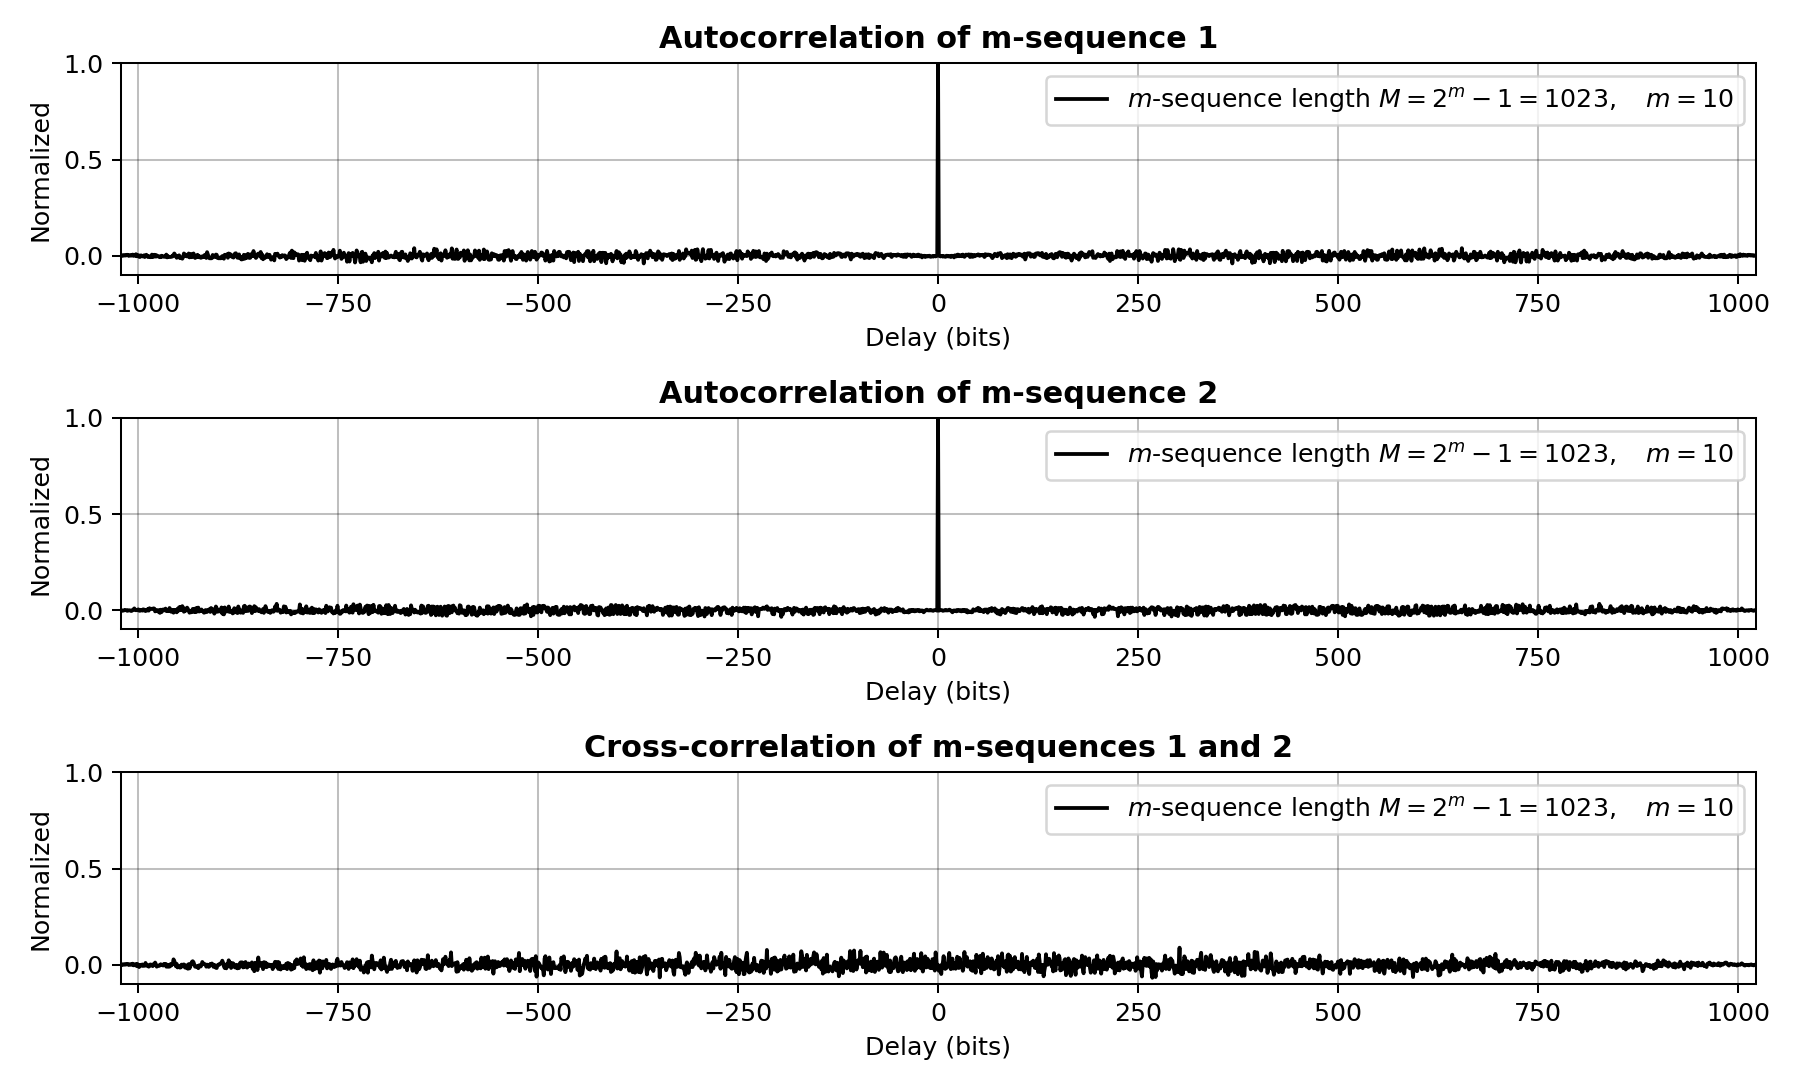

In [6]:
%matplotlib notebook

############################
# Correlation computations #
############################

# Correlation delays (bits/samples)
delays = arange(-M + 1, M)

# Autocorrelations, computed per algebraic m-sequence
autocorrelations = transpose([correlate(b, b, 'full')
    for b in algebraic_m_sequences])

# Cross-correlations of m-sequences 1 & 2 in collection
cross_corr_example = correlate(algebraic_m_sequences[0,:],
    algebraic_m_sequences[1,:],'full') 

######################################
# PLOT: m-sequence 1 autocorrelation #
######################################

# New figure
plt.figure(figsize=(9.9,6));

# Save these axes as ax
ax = plt.subplot(3,1,1);

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot autocorrelation of m-sequence 1 of collection
plt.plot(delays,autocorrelations[:,0]/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Autocorrelation of m-sequence 1',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

######################################
# PLOT: m-sequence 2 autocorrelation #
######################################

# 2nd subplot on common axis
plt.subplot(3,1,2,sharex=ax);

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot autocorrelation of m-sequence 2 of collection
plt.plot(delays,autocorrelations[:,1]/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Autocorrelation of m-sequence 2',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

############################################
# PLOT: m-sequence 1 & 2 cross-correlation #
############################################

# 3rd subplot on common axis
plt.subplot(3,1,3,sharex=ax)

# Add grid
plt.grid(c='k',alpha=0.25);

# Plot cross-correlation of m-sequences 1 and 2
plt.plot(delays,cross_corr_example/M,c='k',
    label='$m$-sequence length $M=2^m-1 = ' \
    + str(int(2**deg - 1)) \
    + ',\quad m = ' + str(deg) + '$');

# Set axis limits
plt.xlim([-M+1,M]);
plt.ylim([-0.1,1])

# Title
plt.title(r'Cross-correlation of m-sequences 1 and 2',weight='bold')

# Label axes
plt.ylabel(r'Normalized')
plt.xlabel(r'Delay (bits)')

# Legend
plt.legend()

# Optimize subplot layout
plt.tight_layout()

In [7]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, Reshape, LSTM
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, Accuracy;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

In [8]:
p = 4
N_epoch = 10000
pct_validation = 0
N_batch = 2**deg - 1
learning_rate = 0.001

In [9]:
# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])
Y = array([b[p,(n + deg)] for n in range(b.shape[1] - deg - 1)])

In [10]:
x = Input(shape=(deg,))
h = Dense(deg,activation='sigmoid',use_bias=False,kernel_initializer='zeros')(x)
y = Dense(1,activation='sigmoid',use_bias=False,kernel_initializer='zeros')(h)
model = Model(x,y)

In [11]:
###########################
# Define loss & optimizer #
###########################

# Set RMSprop optimization for 
# speed-of-convergence purposes
opt = RMSprop(
    learning_rate=learning_rate,
    epsilon=1e-07,
    name="RMSprop"
);

# Model compilation, using categorical
# cross-entropy error w/ RMSprop
model.compile(
    
    # Error/loss function
    loss='binary_crossentropy', 
    
    # Use RMSprop
    optimizer=opt,
    
    # List metrics here
    metrics=[
        CategoricalAccuracy(),
        Accuracy(),
        TruePositives(),
        TrueNegatives(),
        FalsePositives(),
        FalseNegatives()
    ]
);

# Print a summary table
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=pct_validation,
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False
);

Train on 1023 samples
Epoch 1/10000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 511.0000 - false_positives: 0.0000e+00 - false_negatives: 512.0000
Epoch 2/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6932 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 3/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 4/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_posi

Epoch 33/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 34/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 35/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 36/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - 

Epoch 65/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 66/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 67/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 68/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - 

Epoch 97/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 511.0000 - false_positives: 0.0000e+00 - false_negatives: 512.0000
Epoch 98/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 99/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 511.0000 - false_positives: 0.0000e+00 - false_negatives: 512.0000
Epoch 100/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 -

Epoch 129/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 511.0000 - false_positives: 0.0000e+00 - false_negatives: 512.0000
Epoch 130/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 131/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 511.0000 - false_positives: 0.0000e+00 - false_negatives: 512.0000
Epoch 132/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 161/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 162/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 163/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 164/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 193/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 194/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 195/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 196/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 225/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 226/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 227/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 228/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 257/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 258/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 259/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 260/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 289/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 290/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 291/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 292/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 321/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 322/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 323/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 324/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 353/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 354/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 355/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 356/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 385/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 386/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 387/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 388/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 417/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 418/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 419/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 420/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 449/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 450/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 451/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 452/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.000

Epoch 481/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 484.0000 - true_negatives: 28.0000 - false_positives: 483.0000 - false_negatives: 28.0000
Epoch 482/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_negatives: 0.0000e+00
Epoch 483/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 424.0000 - true_negatives: 48.0000 - false_positives: 463.0000 - false_negatives: 88.0000
Epoch 484/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 0.0000e+00 - false_positives: 511.0000 - false_ne

Epoch 514/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 484.0000 - true_negatives: 22.0000 - false_positives: 489.0000 - false_negatives: 28.0000
Epoch 515/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 190.0000 - false_positives: 321.0000 - false_negatives: 196.0000
Epoch 516/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 484.0000 - true_negatives: 28.0000 - false_positives: 483.0000 - false_negatives: 28.0000
Epoch 517/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 190.0000 - false_positives: 321.0000 - false_negative

Epoch 547/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 548/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 420.0000 - true_negatives: 84.0000 - false_positives: 427.0000 - false_negatives: 92.0000
Epoch 549/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 550/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 420.0000 - true_negatives: 99.0000 - false_positives: 412.0000 - false_negativ

Epoch 580/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 189.0000 - false_positives: 322.0000 - false_negatives: 196.0000
Epoch 581/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 316.0000
Epoch 582/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 189.0000 - false_positives: 322.0000 - false_negatives: 196.0000
Epoch 583/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_nega

Epoch 613/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 316.0000
Epoch 614/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_negatives: 196.0000
Epoch 615/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 316.0000
Epoch 616/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_nega

Epoch 646/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_negatives: 256.0000
Epoch 647/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 317.0000 - false_positives: 194.0000 - false_negatives: 256.0000
Epoch 648/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_negatives: 256.0000
Epoch 649/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 317.0000 - false_positives: 194.0000 - false_nega

Epoch 679/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 317.0000 - false_positives: 194.0000 - false_negatives: 256.0000
Epoch 680/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_negatives: 256.0000
Epoch 681/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 317.0000 - false_positives: 194.0000 - false_negatives: 256.0000
Epoch 682/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 195.0000 - false_positives: 316.0000 - false_nega

Epoch 712/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 196.0000 - false_positives: 315.0000 - false_negatives: 256.0000
Epoch 713/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 232.0000 - true_negatives: 317.0000 - false_positives: 194.0000 - false_negatives: 280.0000
Epoch 714/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 196.0000 - false_positives: 315.0000 - false_negatives: 256.0000
Epoch 715/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 232.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_nega

Epoch 745/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 232.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 280.0000
Epoch 746/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 747/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 232.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 280.0000
Epoch 748/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_nega

Epoch 778/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 779/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 284.0000
Epoch 780/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 781/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_nega

Epoch 811/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 260.0000
Epoch 812/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 813/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 260.0000
Epoch 814/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_nega

Epoch 844/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 845/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 256.0000
Epoch 846/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 316.0000 - false_positives: 195.0000 - false_negatives: 256.0000
Epoch 847/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_nega

Epoch 877/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 256.0000
Epoch 878/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 256.0000
Epoch 879/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 880/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negativ

Epoch 910/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 911/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 912/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 913/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negative

Epoch 943/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 944/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 945/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 946/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negative

Epoch 976/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 977/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 978/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 979/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negative

Epoch 1009/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6929 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1010/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1011/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1012/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1042/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1043/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6928 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1044/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1045/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6927 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1075/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1076/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1077/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1078/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6926 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1108/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1109/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1110/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1111/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6925 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1141/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1142/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 256.0000
Epoch 1143/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1144/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6923 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1174/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1175/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1176/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1177/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6921 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1207/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1208/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1209/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1210/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6919 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1240/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1241/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1242/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1243/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1273/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1274/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1275/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6915 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1276/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6914 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1306/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1307/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1308/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1309/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6912 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1339/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1340/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1341/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1342/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6909 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1372/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6906 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1373/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6906 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1374/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6906 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1375/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6906 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1405/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1406/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1407/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1408/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6902 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1438/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1439/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1440/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1441/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6899 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1471/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6896 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1472/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1473/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1474/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6895 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1504/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6892 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1505/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6891 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1506/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6891 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1507/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6891 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1537/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1538/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1539/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1540/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6887 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1570/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1571/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1572/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 252.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 260.0000
Epoch 1573/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6883 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1603/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1604/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1605/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1606/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6878 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1636/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6874 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1637/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1638/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1639/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6873 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1669/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6869 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1670/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6868 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1671/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6868 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1672/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6868 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1702/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1703/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1704/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1705/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6863 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1735/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1736/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1737/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1738/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6858 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1768/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6853 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1769/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6852 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1770/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6852 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1771/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6852 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1801/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6847 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1802/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6847 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1803/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6847 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1804/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6846 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1834/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6841 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1835/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6841 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1836/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6841 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1837/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6840 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1867/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6835 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1868/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6835 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1869/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6835 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1870/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6834 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1900/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6829 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1901/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6829 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 344.0000
Epoch 1902/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6828 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 228.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 284.0000
Epoch 1903/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6828 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1933/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6822 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 344.0000
Epoch 1934/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6822 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 344.0000
Epoch 1935/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6822 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 344.0000
Epoch 1936/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6822 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 1966/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6816 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 1967/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6816 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_negatives: 344.0000
Epoch 1968/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6816 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 1969/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6815 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 448.0000 - false_positives: 63.0000 - false_nega

Epoch 1999/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6809 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2000/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6809 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2001/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6809 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2002/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6809 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2032/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6803 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2033/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2034/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2035/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6802 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2065/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6796 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2066/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6796 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2067/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2068/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6795 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2098/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6789 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2099/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6788 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2100/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6788 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2101/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6788 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2131/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6782 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2132/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6781 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2133/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6781 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2134/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6781 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2164/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2165/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2166/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2167/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6774 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2197/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6767 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2198/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6767 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2199/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6766 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2200/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6766 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2230/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6759 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2231/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6759 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2232/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6759 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2233/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6759 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2263/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2264/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6752 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2265/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6751 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2266/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6751 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2296/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2297/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2298/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6744 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2299/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6743 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2329/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2330/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2331/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2332/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6736 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2362/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6728 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2363/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6728 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2364/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6728 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2365/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6728 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2395/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6720 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2396/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6720 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2397/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6720 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2398/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6720 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2428/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6712 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2429/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6712 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2430/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6712 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2431/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6712 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2461/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2462/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2463/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2464/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6704 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_nega

Epoch 2494/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6696 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2495/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6696 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_negatives: 344.0000
Epoch 2496/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6696 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2497/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6695 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 442.0000 - false_positives: 69.0000 - false_ne

Epoch 2527/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2528/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2529/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6688 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2530/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6687 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_

Epoch 2560/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6680 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2561/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6680 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2562/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6679 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2563/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6679 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_

Epoch 2593/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6672 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2594/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6671 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2595/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6671 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2596/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6671 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_

Epoch 2626/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2627/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2628/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2629/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6662 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_

Epoch 2659/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6655 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2660/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6655 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2661/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2662/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_

Epoch 2692/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2693/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2694/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 406.0000 - false_positives: 105.0000 - false_negatives: 344.0000
Epoch 2695/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_

Epoch 2725/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6638 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2726/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6638 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2727/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2728/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_

Epoch 2758/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2759/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2760/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_negatives: 344.0000
Epoch 2761/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6628 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 407.0000 - false_positives: 104.0000 - false_

Epoch 2791/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2792/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2793/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2794/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_nega

Epoch 2824/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2825/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2826/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6611 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_negatives: 344.0000
Epoch 2827/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6610 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 413.0000 - false_positives: 98.0000 - false_nega

Epoch 2857/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6602 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 419.0000 - false_positives: 92.0000 - false_negatives: 344.0000
Epoch 2858/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 419.0000 - false_positives: 92.0000 - false_negatives: 344.0000
Epoch 2859/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 419.0000 - false_positives: 92.0000 - false_negatives: 344.0000
Epoch 2860/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6601 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 419.0000 - false_positives: 92.0000 - false_nega

Epoch 2890/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6591 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2891/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6591 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2892/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6590 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2893/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6590 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_nega

Epoch 2923/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6579 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2924/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6579 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2925/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6579 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 344.0000
Epoch 2926/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6578 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 168.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_nega

Epoch 2956/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 434.0000 - false_positives: 77.0000 - false_negatives: 340.0000
Epoch 2957/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 449.0000 - false_positives: 62.0000 - false_negatives: 340.0000
Epoch 2958/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6566 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 449.0000 - false_positives: 62.0000 - false_negatives: 340.0000
Epoch 2959/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6566 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 449.0000 - false_positives: 62.0000 - false_nega

Epoch 2989/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6554 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 2990/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6553 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 2991/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6553 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 2992/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6552 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_nega

Epoch 3022/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6540 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3023/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6539 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3024/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6539 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3025/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6538 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_nega

Epoch 3055/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6525 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3056/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6524 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3057/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6524 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_negatives: 340.0000
Epoch 3058/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6524 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 469.0000 - false_positives: 42.0000 - false_nega

Epoch 3088/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3089/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6509 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3090/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6509 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3091/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6508 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3121/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6494 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3122/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3123/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3124/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6492 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3154/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3155/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3156/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3157/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6476 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3187/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6461 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3188/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6460 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3189/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6460 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3190/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6459 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3220/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6444 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3221/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6443 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3222/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6443 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3223/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6442 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3253/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6427 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3254/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3255/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6426 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3256/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6425 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3286/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6409 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3287/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6408 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3288/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6408 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3289/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6407 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3319/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6391 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3320/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6391 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3321/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6390 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3322/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6390 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3352/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6373 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3353/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6373 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3354/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3355/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3385/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6355 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3386/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6355 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3387/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 340.0000
Epoch 3388/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 172.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3418/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6337 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3419/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6337 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3420/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3421/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3451/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6319 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3452/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6318 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3453/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6318 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3454/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3484/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6301 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3485/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3486/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3487/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3517/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3518/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3519/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3520/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3550/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3551/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3552/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3553/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3583/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3584/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3585/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3586/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3616/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6228 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3617/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6228 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3618/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6227 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_negatives: 316.0000
Epoch 3619/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6227 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 379.0000 - false_positives: 132.0000 - false_

Epoch 3649/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6210 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3650/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6210 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3651/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6209 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3652/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6209 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3682/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6192 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3683/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6192 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3684/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6191 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3685/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6191 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3715/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6175 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3716/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6174 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3717/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6174 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3718/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6173 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3748/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6157 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3749/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6156 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3750/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6156 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3751/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6155 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3781/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6140 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3782/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6139 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3783/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6138 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3784/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6138 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3814/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6122 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3815/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6122 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3816/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6121 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3817/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6121 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3847/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6105 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3848/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6105 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3849/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6104 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3850/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6104 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3880/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6088 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3881/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6088 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3882/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6087 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3883/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6087 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3913/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6072 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3914/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6071 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3915/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6071 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3916/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6070 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3946/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6055 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3947/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6055 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3948/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6054 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3949/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6054 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 3979/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6039 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3980/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6038 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3981/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6038 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 3982/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6037 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4012/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6023 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4013/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6022 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4014/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6022 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4015/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6021 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4045/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6007 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4046/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6006 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4047/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6006 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4048/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.6005 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4078/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5991 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4079/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5991 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4080/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5990 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4081/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5990 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4111/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5976 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4112/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5975 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4113/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5975 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4114/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5975 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4144/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5961 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4145/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5960 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4146/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5960 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 316.0000
Epoch 4147/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5959 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 196.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4177/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5946 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 256.0000
Epoch 4178/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5946 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 256.0000
Epoch 4179/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5945 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_negatives: 256.0000
Epoch 4180/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5945 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 378.0000 - false_positives: 133.0000 - false_

Epoch 4210/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4211/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4212/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5931 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4213/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5930 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_

Epoch 4243/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4244/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5917 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4245/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4246/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5916 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_

Epoch 4276/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4277/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5903 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4278/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5902 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 256.0000
Epoch 4279/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5902 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 256.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_

Epoch 4309/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5889 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4310/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5889 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4311/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4312/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5888 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_

Epoch 4342/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5876 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4343/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5875 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4344/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5875 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_negatives: 196.0000
Epoch 4345/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5874 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 258.0000 - false_positives: 253.0000 - false_

Epoch 4375/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5862 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4376/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5862 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4377/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5861 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4378/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5861 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4408/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5849 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4409/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5849 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4410/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4411/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5848 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4441/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4442/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4443/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5836 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4444/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5835 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4474/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5824 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4475/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5823 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4476/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5823 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4477/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5823 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4507/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4508/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4509/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5811 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4510/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5810 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4540/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4541/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4542/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5799 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4543/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5798 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4573/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5788 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4574/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5787 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4575/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5787 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4576/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5787 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4606/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5776 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4607/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5776 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4608/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4609/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5775 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4639/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5765 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4640/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4641/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4642/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5764 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4672/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5754 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4673/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5753 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4674/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5753 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4675/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5753 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4705/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5743 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4706/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5742 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4707/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5742 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4708/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5742 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4738/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4739/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4740/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5732 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4741/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5731 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4771/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4772/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5722 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4773/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5721 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4774/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5721 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4804/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5712 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4805/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4806/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4807/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5711 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4837/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5702 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4838/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5701 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4839/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5701 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4840/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5701 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4870/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5692 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4871/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5692 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4872/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5691 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4873/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5691 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4903/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4904/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4905/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4906/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5682 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4936/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5673 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4937/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5673 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4938/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5673 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4939/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5672 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_

Epoch 4969/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5664 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 4970/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5664 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 4971/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 252.0000 - false_positives: 259.0000 - false_negatives: 196.0000
Epoch 4972/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5663 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 239.0000 - false_positives: 272.0000 - false_

Epoch 5002/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5655 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5003/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5655 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5004/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5005/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5654 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5035/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5036/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5037/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5646 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 196.0000
Epoch 5038/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5645 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 316.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5068/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5069/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 365.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 147.0000
Epoch 5070/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5071/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5637 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5101/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5102/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5103/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5629 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5104/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5628 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5134/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5621 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5135/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5621 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5136/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5137/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5620 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5167/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5613 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5168/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5169/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5170/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5612 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5200/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5201/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5605 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5202/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5604 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5203/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5604 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5233/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 236.0000 - false_positives: 275.0000 - false_negatives: 116.0000
Epoch 5234/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5235/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5597 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_negatives: 116.0000
Epoch 5236/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5596 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 237.0000 - false_positives: 274.0000 - false_

Epoch 5266/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5267/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5268/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5269/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5589 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_

Epoch 5299/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5582 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5300/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5582 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 146.0000 - false_positives: 365.0000 - false_negatives: 116.0000
Epoch 5301/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5582 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5302/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5581 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 137.0000 - false_positives: 374.0000 - false_

Epoch 5332/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5575 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5333/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5574 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 134.0000 - false_positives: 377.0000 - false_negatives: 116.0000
Epoch 5334/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5574 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5335/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5574 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 136.0000 - false_positives: 375.0000 - false_

Epoch 5365/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5568 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 138.0000 - false_positives: 373.0000 - false_negatives: 116.0000
Epoch 5366/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 128.0000 - false_positives: 383.0000 - false_negatives: 116.0000
Epoch 5367/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5368/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5567 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_

Epoch 5398/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5561 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5399/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5560 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5400/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5560 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 130.0000 - false_positives: 381.0000 - false_negatives: 116.0000
Epoch 5401/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5560 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 145.0000 - false_positives: 366.0000 - false_

Epoch 5431/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5554 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 116.0000
Epoch 5432/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5554 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 133.0000 - false_positives: 378.0000 - false_negatives: 116.0000
Epoch 5433/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5553 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5434/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5553 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 130.0000 - false_positives: 381.0000 - false_

Epoch 5464/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5465/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5466/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 133.0000 - false_positives: 378.0000 - false_negatives: 116.0000
Epoch 5467/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5547 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 113.0000 - false_positives: 398.0000 - false_

Epoch 5497/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5541 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 116.0000
Epoch 5498/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5540 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 117.0000 - false_positives: 394.0000 - false_negatives: 116.0000
Epoch 5499/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5540 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 129.0000 - false_positives: 382.0000 - false_negatives: 116.0000
Epoch 5500/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5540 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 396.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_

Epoch 5530/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 132.0000 - false_positives: 379.0000 - false_negatives: 56.0000
Epoch 5531/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 116.0000 - false_positives: 395.0000 - false_negatives: 56.0000
Epoch 5532/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 56.0000
Epoch 5533/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5534 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_neg

Epoch 5563/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5528 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 147.0000 - false_positives: 364.0000 - false_negatives: 56.0000
Epoch 5564/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5528 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 56.0000
Epoch 5565/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5528 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 113.0000 - false_positives: 398.0000 - false_negatives: 56.0000
Epoch 5566/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5527 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_neg

Epoch 5596/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 146.0000 - false_positives: 365.0000 - false_negatives: 56.0000
Epoch 5597/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5598/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5522 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 56.0000
Epoch 5599/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5521 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 123.0000 - false_positives: 388.0000 - false_neg

Epoch 5629/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5516 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 56.0000
Epoch 5630/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5516 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 110.0000 - false_positives: 401.0000 - false_negatives: 56.0000
Epoch 5631/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5516 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 116.0000 - false_positives: 395.0000 - false_negatives: 56.0000
Epoch 5632/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5515 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 124.0000 - false_positives: 387.0000 - false_neg

Epoch 5662/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5663/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5664/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 122.0000 - false_positives: 389.0000 - false_negatives: 56.0000
Epoch 5665/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5510 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_neg

Epoch 5695/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 110.0000 - false_positives: 401.0000 - false_negatives: 56.0000
Epoch 5696/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 124.0000 - false_positives: 387.0000 - false_negatives: 56.0000
Epoch 5697/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 111.0000 - false_positives: 400.0000 - false_negatives: 56.0000
Epoch 5698/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5504 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 117.0000 - false_positives: 394.0000 - false_neg

Epoch 5728/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 118.0000 - false_positives: 393.0000 - false_negatives: 56.0000
Epoch 5729/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5730/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5499 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5731/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5498 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 110.0000 - false_positives: 401.0000 - false_neg

Epoch 5761/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 127.0000 - false_positives: 384.0000 - false_negatives: 56.0000
Epoch 5762/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5763/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 126.0000 - false_positives: 385.0000 - false_negatives: 56.0000
Epoch 5764/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5493 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_neg

Epoch 5794/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 116.0000 - false_positives: 395.0000 - false_negatives: 56.0000
Epoch 5795/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 113.0000 - false_positives: 398.0000 - false_negatives: 56.0000
Epoch 5796/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 124.0000 - false_positives: 387.0000 - false_negatives: 56.0000
Epoch 5797/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5488 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 122.0000 - false_positives: 389.0000 - false_neg

Epoch 5827/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5483 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 56.0000
Epoch 5828/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5483 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 106.0000 - false_positives: 405.0000 - false_negatives: 56.0000
Epoch 5829/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5483 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 106.0000 - false_positives: 405.0000 - false_negatives: 56.0000
Epoch 5830/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5482 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 456.0000 - true_negatives: 107.0000 - false_positives: 404.0000 - false_neg

Epoch 5860/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 32.0000
Epoch 5861/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5478 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 117.0000 - false_positives: 394.0000 - false_negatives: 32.0000
Epoch 5862/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 32.0000
Epoch 5863/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5477 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 111.0000 - false_positives: 400.0000 - false_neg

Epoch 5893/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5473 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_negatives: 32.0000
Epoch 5894/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5473 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 106.0000 - false_positives: 405.0000 - false_negatives: 32.0000
Epoch 5895/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5472 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 111.0000 - false_positives: 400.0000 - false_negatives: 32.0000
Epoch 5896/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5472 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 112.0000 - false_positives: 399.0000 - false_neg

Epoch 5926/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 494.0000 - true_negatives: 82.0000 - false_positives: 429.0000 - false_negatives: 18.0000
Epoch 5927/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 490.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 22.0000
Epoch 5928/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5468 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 32.0000
Epoch 5929/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5467 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 480.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negativ

Epoch 5959/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5463 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 5960/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5463 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 5961/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5463 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 5962/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5463 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 5992/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5458 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives: 8.0000
Epoch 5993/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5458 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 5994/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5458 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 5995/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5458 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6025/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5454 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 72.0000 - false_positives: 439.0000 - false_negatives: 8.0000
Epoch 6026/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5454 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6027/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5454 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives: 8.0000
Epoch 6028/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5453 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6058/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5449 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6059/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5449 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6060/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5449 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6061/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5449 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6091/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6092/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 71.0000 - false_positives: 440.0000 - false_negatives: 8.0000
Epoch 6093/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6094/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5445 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6124/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5441 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6125/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5441 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 71.0000 - false_positives: 440.0000 - false_negatives: 8.0000
Epoch 6126/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5440 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 75.0000 - false_positives: 436.0000 - false_negatives: 8.0000
Epoch 6127/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5440 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6157/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5437 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6158/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5436 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6159/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5436 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 75.0000 - false_positives: 436.0000 - false_negatives: 8.0000
Epoch 6160/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5436 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6190/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6191/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives: 8.0000
Epoch 6192/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6193/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5432 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6223/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5428 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6224/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5428 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6225/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5428 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6226/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5428 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives:

Epoch 6256/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6257/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6258/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6259/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5424 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6289/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5421 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 8.0000
Epoch 6290/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5421 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 505.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 7.0000
Epoch 6291/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 8.0000
Epoch 6292/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5420 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 504.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6322/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5417 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 505.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 7.0000
Epoch 6323/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5417 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 505.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives: 7.0000
Epoch 6324/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5417 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 506.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 6.0000
Epoch 6325/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5417 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 506.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives:

Epoch 6355/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5413 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6356/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5413 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives: 4.0000
Epoch 6357/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5413 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6358/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5413 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 73.0000 - false_positives: 438.0000 - false_negatives:

Epoch 6388/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6389/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5410 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 71.0000 - false_positives: 440.0000 - false_negatives: 4.0000
Epoch 6390/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5409 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6391/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5409 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 76.0000 - false_positives: 435.0000 - false_negatives:

Epoch 6421/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5406 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6422/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5406 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6423/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5406 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6424/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5406 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6454/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6455/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5403 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6456/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6457/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5402 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6487/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5399 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 75.0000 - false_positives: 436.0000 - false_negatives: 4.0000
Epoch 6488/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5399 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6489/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5399 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 83.0000 - false_positives: 428.0000 - false_negatives: 4.0000
Epoch 6490/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5399 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6520/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5396 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6521/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5396 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6522/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5396 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 4.0000
Epoch 6523/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5396 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6553/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5393 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6554/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5393 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6555/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5393 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6556/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5392 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6586/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5390 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6587/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5390 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6588/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5389 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6589/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5389 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives:

Epoch 6619/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6620/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6621/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6622/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5386 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6652/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5383 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 4.0000
Epoch 6653/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5383 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6654/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5383 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6655/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5383 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6685/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 4.0000
Epoch 6686/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 75.0000 - false_positives: 436.0000 - false_negatives: 4.0000
Epoch 6687/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6688/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5380 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6718/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5378 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 4.0000
Epoch 6719/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5377 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6720/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5377 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6721/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5377 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6751/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5375 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6752/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5375 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6753/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5375 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 4.0000
Epoch 6754/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5374 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6784/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6785/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6786/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 4.0000
Epoch 6787/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5372 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives:

Epoch 6817/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6818/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6819/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 4.0000
Epoch 6820/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5369 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6850/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5366 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6851/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5366 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 4.0000
Epoch 6852/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5366 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 4.0000
Epoch 6853/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5366 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives:

Epoch 6883/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 4.0000
Epoch 6884/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6885/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6886/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5364 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6916/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5361 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6917/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5361 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6918/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5361 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 4.0000
Epoch 6919/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5361 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 6949/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6950/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6951/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6952/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5359 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives:

Epoch 6982/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6983/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6984/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 4.0000
Epoch 6985/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5356 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 508.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives:

Epoch 7015/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7016/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7017/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7018/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5354 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5352 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7048/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5351 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 7049/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5351 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7050/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5351 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.00

Epoch 7080/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 7081/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7082/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7083/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5349 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5347 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7113/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5347 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7114/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5347 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7115/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5347 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7145/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5345 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7146/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5345 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7147/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5345 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7148/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5345 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5343 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7178/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7179/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7180/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5342 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.00

Epoch 7210/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5340 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7211/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5340 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7212/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5340 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7213/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5340 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7243/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7244/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7245/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5338 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7275/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7276/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7277/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7278/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5336 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7308/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7309/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7310/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5334 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7340/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5332 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7341/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5332 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7342/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5332 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7343/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5332 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5330 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7373/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5330 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7374/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5330 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7375/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5330 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7405/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 7406/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7407/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7408/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5328 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5326 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7438/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5326 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7439/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5326 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7440/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5326 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7470/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5325 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7471/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5325 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7472/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5324 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7473/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5324 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5323 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7503/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5323 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7504/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5323 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 7505/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5323 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7535/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5321 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7536/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5321 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7537/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5321 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7538/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5321 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5319 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7568/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5319 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7569/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5319 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7570/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5319 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 7600/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7601/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7602/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7603/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5317 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7633/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7634/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 75.0000 - false_positives: 436.0000 - false_negatives: 0.0000e+00
Epoch 7635/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5316 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.00

Epoch 7665/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7666/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 7667/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7668/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5314 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5312 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 7698/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5312 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7699/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5312 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 7700/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5312 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7730/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5311 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7731/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5311 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7732/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5311 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7733/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5311 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5309 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7763/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5309 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7764/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5309 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7765/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5309 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 7795/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7796/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7797/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 81.0000 - false_positives: 430.0000 - false_negatives: 0.0000e+00
Epoch 7798/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5308 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5306 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7828/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5306 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7829/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5306 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7830/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5306 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 7860/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5305 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7861/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5305 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7862/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5305 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7863/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5304 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5303 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 7893/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5303 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 7894/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5303 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 7895/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5303 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 7925/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7926/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7927/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7928/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5302 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 7957/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 7958/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7959/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7960/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5300 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7990/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7991/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 7992/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5299 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 8022/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5297 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8023/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5297 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8024/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5297 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8025/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5297 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5296 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8055/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5296 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8056/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5296 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8057/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5296 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 8087/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8088/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 8089/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5295 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8090/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5294 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5293 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8120/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5293 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8121/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5293 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8122/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5293 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.00

Epoch 8152/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5292 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8153/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5292 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8154/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5292 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8155/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5292 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5291 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8185/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5291 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 77.0000 - false_positives: 434.0000 - false_negatives: 0.0000e+00
Epoch 8186/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5291 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8187/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5291 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 8217/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8218/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8219/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8220/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5289 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5288 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8250/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5288 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8251/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5288 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 0.0000e+00
Epoch 8252/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5288 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 8282/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5287 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 8283/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5287 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8284/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5287 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8285/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5287 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5286 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8315/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5286 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8316/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5285 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8317/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5285 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 8347/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5284 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8348/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5284 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8349/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5284 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8350/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5284 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8380/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8381/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8382/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5283 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.00

Epoch 8412/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8413/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8414/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8415/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5282 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8445/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8446/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8447/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5281 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 8477/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5280 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 8478/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5280 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8479/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5280 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 0.0000e+00
Epoch 8480/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5279 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5278 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8510/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5278 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8511/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5278 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8512/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5278 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 78.0000 - false_positives: 433.0000 - false_negatives: 0.00

Epoch 8542/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5277 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8543/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5277 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 8544/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5277 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8545/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5277 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - fals

Epoch 8574/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8575/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8576/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8577/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5276 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5275 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8607/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5275 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8608/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5275 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8609/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5275 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.00

Epoch 8639/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5274 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8640/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5274 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8641/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5274 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8642/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5274 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8672/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8673/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8674/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5273 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.00

Epoch 8704/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8705/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8706/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 8707/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5272 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 8737/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8738/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8739/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8740/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5271 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 8769/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5270 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8770/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5270 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8771/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5270 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 8772/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5270 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5269 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8802/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5269 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8803/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5269 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8804/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5269 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 8834/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5268 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 8835/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5268 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8836/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5268 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8837/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5268 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

Epoch 8866/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5267 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8867/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5267 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8868/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5267 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8869/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5267 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

Epoch 8898/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8899/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8900/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8901/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5266 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 8930/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5265 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 8931/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5265 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8932/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5265 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 8933/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5265 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 0.0000e+00
Epoch 8963/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 8964/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8965/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5264 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.00

Epoch 8995/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 8996/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 8997/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 8998/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5263 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5262 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9028/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5262 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9029/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5262 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9030/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5262 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.00

Epoch 9060/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9061/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9062/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9063/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5261 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5260 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9093/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5260 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9094/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5260 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9095/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5260 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.00

Epoch 9125/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5259 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 9126/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5259 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9127/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5259 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9128/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5259 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 9157/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5258 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9158/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5258 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9159/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5258 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 77.0000 - false_positives: 434.0000 - false_negatives: 0.0000e+00
Epoch 9160/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5258 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5257 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9190/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5257 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9191/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5257 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9192/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5257 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 9222/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9223/10000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.5256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9224/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9225/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5256 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 9254/10000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9255/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9256/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9257/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

Epoch 9286/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9287/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9288/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9289/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5255 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5254 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9319/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5254 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9320/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5254 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9321/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5254 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 9351/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5253 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9352/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5253 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9353/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5253 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9354/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5253 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9384/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 0.0000e+00
Epoch 9385/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9386/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5252 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.00

Epoch 9416/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5251 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9417/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5251 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9418/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5251 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9419/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5251 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9449/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9450/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9451/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5250 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.00

Epoch 9481/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9482/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9483/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9484/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - fals

Epoch 9513/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 77.0000 - false_positives: 434.0000 - false_negatives: 0.0000e+00
Epoch 9514/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9515/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 74.0000 - false_positives: 437.0000 - false_negatives: 0.0000e+00
Epoch 9516/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5249 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 9545/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5248 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9546/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5248 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9547/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5248 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9548/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5248 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 5us/sample - loss: 0.5247 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9578/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5247 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9579/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5247 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9580/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5247 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.00

Epoch 9610/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9611/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9612/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9613/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5246 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 9643/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 70.0000 - false_positives: 441.0000 - false_negatives: 0.0000e+00
Epoch 9644/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9645/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.00

Epoch 9675/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9676/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9677/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9678/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5245 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 9707/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5244 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00
Epoch 9708/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5244 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9709/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5244 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9710/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5244 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 9739/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5243 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9740/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5243 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9741/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5243 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9742/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5243 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9772/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9773/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9774/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.00

Epoch 9804/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9805/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5242 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 71.0000 - false_positives: 440.0000 - false_negatives: 0.0000e+00
Epoch 9806/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9807/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 9836/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9837/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9838/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9839/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5241 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - fals

1023/1023 [==============================] - 0s 6us/sample - loss: 0.5240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 65.0000 - false_positives: 446.0000 - false_negatives: 0.0000e+00
Epoch 9869/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - false_negatives: 0.0000e+00
Epoch 9870/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9871/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5240 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.00

Epoch 9901/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 68.0000 - false_positives: 443.0000 - false_negatives: 0.0000e+00
Epoch 9902/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9903/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9904/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - fals

Epoch 9934/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5239 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9935/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 69.0000 - false_positives: 442.0000 - false_negatives: 0.0000e+00
Epoch 9936/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 66.0000 - false_positives: 445.0000 - false_negatives: 0.0000e+00
Epoch 9937/10000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 9967/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9968/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9969/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 63.0000 - false_positives: 448.0000 - false_negatives: 0.0000e+00
Epoch 9970/10000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.5238 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 64.0000 - false_positives: 447.0000 - fals

Epoch 10000/10000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5237 - categorical_accuracy: 1.0000 - accuracy: 0.0000e+00 - true_positives: 512.0000 - true_negatives: 67.0000 - false_positives: 444.0000 - false_negatives: 0.0000e+00


<IPython.core.display.Javascript object>


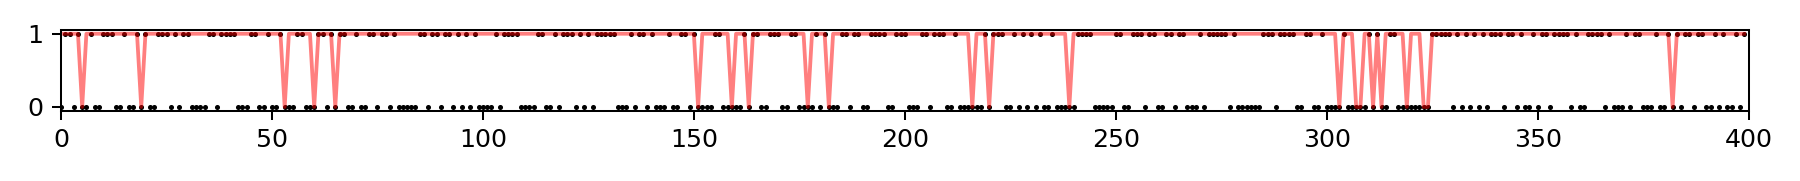

In [13]:
plt.figure(figsize=(9.9,1))
plt.plot(Y[0:400],'.',c='k',markersize=2)
plt.plot((model.predict(X.astype('float64'))>=0.5)[0:400],c='r',alpha=0.5)
plt.xlim([0,400])
plt.tight_layout()

In [100]:
###############################################################################
#
###############################################################################

def num2cmap(x, max_magnitude, cmap, epsilon=1e-9):
    """
    """
    return cmap(0.5 + x / (epsilon + 2 * max_magnitude))

###############################################################################
#
###############################################################################

def lfsr_xor_connection(n, y_register=0, y_feedback=-0.1, lw=1, xor_size=8):
    """
    """
    #############
    # XOR input #
    #############

    # Wire y-offset into XOR gate
    dy = 0.005

    # Verticle register wiring offset into XOR gate
    plt.plot([n + 0.2, n + 0.2], [-0.1, y_register - dy], lw=1, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via tap
    plt.plot([n + 0.2, n + 0.55], [y_register - dy, 
        y_register - dy], lw=lw, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via register
    plt.plot([n, n + 0.55], [y_register + dy, y_register + dy], lw=1, c='k')

    ############
    # XOR gate #
    ############
    
    # XOR gate contribution from '|' marker
    plt.plot([n + 0.55], [y_register],
        '|', c='k', lw=lw, markersize=xor_size)
    
    # XOR gate contribution from '>' marker
    plt.plot([n + 0.67], [y_register], 
        '>', c='k', lw=lw, markersize=(xor_size - 1))

    ##############
    # XOR output #
    ##############

    # Output wire from XOR gate (level w/ register bits)
    plt.plot([n + 0.6, n + 1], [y_register, y_register], c='k', lw=lw)

###############################################################################
#
###############################################################################

def lfsr_shift_connection(n, y_register=0, lw=1, arrow_size=8):
    """
    """
    # Actual wiring between bits [n, n + 1]
    plt.plot([n, n + 1], [y_register, y_register], c='k', lw=lw)

    # Shift operator on wire b/w bits [n, n + 1]
    plt.plot([n + 0.5], [y_register], '4', c='k',
        lw=lw, markersize=arrow_size)

###############################################################################
#
###############################################################################

def init_input_nodes(deg, seed_bits, markersize=8):
    """
    """
    # For each n'th bit...
    for n in range(deg):

        # Assign black node for bit=1, white for bit=0
        nth_node_color = 'k' if seed_bits[n] else 'w'

        ########################################
        # Plot LFSR n'th input node of network #
        ########################################

        # Plot the n'th node in the register seed state
        plt.plot([n],[0],'o', markersize=markersize, 
            markeredgecolor='k', 
            markerfacecolor=nth_node_color);

###############################################################################
#
###############################################################################

def init_hidden_nodes(deg, y_layer=0.5, markersize=8):
    """
    """
    # For each n'th node...
    for n in range(deg):

        # Plot hidden node @ coordinate (n,y_layer)
        plt.plot([n], [y_layer], 'o', markersize=markersize,
            markeredgecolor='k', markerfacecolor='w');

###############################################################################
#
###############################################################################

def init_decision_nodes(x_node, y_lower=0.8, y_upper=1, markersize=8):
    """
    """
    # Sigmoidal class prediction node
    plt.plot([x_node],[y_lower],'o',
        markersize=markersize,
        markeredgecolor='k',
        markerfacecolor='w');

    # Thresholded bit prediction node
    plt.plot([x_node],[y_upper],'o',
        markersize=markersize,
        markeredgecolor='k',
        markerfacecolor='w');

###############################################################################
#
###############################################################################
 
def network_weight_coloration(model, colormap='twilight_shifted'):
    """
    """
    # Max. weight modulus across network
    max_weight = max([
        max(model.weights[0].numpy()), # Layer 0 (input)
        max(model.weights[1].numpy()) # Layer 1 (hidden)
    ])

    # Define colormap via matplotlib
    cmap = plt.get_cmap(colormap)

    # Color values for weights of Layer 0
    layer0_colors = num2cmap(
        model.weights[0].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)

    # Color values for weights of Layer 1
    layer1_colors = num2cmap(
        model.weights[1].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)
    
    # Return color arrays (w/ depth = 4)
    return layer0_colors, layer1_colors

###############################################################################
#
###############################################################################

def lfsr_polynomial_wiring(deg, taps, y_register=0,
    y_feedback=-0.1, lw=1, arrow_size=8, xor_size=8):
    """
    """
    # For each n'th polynomial coeff...
    for n in range(deg - 1):
        
        #######################################
        # Decorate wiring b/w bits [n, n + 1] #
        #######################################

        # If nonzero n'th coefficient...
        if n > 0 and taps[n]:

            # Place X0R gate w/ feedback taps
            lfsr_xor_connection(n, y_register=y_register, 
                y_feedback=y_feedback, lw=lw, xor_size=xor_size)

        # n'th coefficient is 0...
        else:

            # Place ordinary shift operator
            lfsr_shift_connection(n, y_register=y_register, 
                lw=lw, arrow_size=arrow_size)

###############################################################################
#
###############################################################################

def lfsr_feedback_loop_wiring(x_midpt, deg,
    y_register=0, y_feedback=-0.1, lw=1, arrow_size=8):
    """
    """
    ##############################################
    # Register I/O wiring (level with LFSR bits) #
    ##############################################

    # Input wire (level with register)
    plt.plot([0, -0.5], [y_register, y_register], c='k', lw=lw)

    # Shift operator decorating input wire
    plt.plot([-0.25], [y_register], '4', c='k',
        markersize=arrow_size)

    # Output wire (level with register)
    plt.plot([deg - 1, deg - 0.5], 
        [y_register, y_register],
        c='k', lw=lw)

    ###################################
    # Descending feedback loop wiring #
    ###################################

    # LFSR output wire, descending into feedback loop
    plt.plot([deg - 0.5, deg - 0.5], [y_register, y_feedback],
        c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([deg - 0.5], [(y_register + y_feedback) / 2],
        '1', c='k', markersize=arrow_size)

    ##################################
    # Ascending feedback loop wiring #
    ##################################

    # LFSR input wire, ascending out of feedback loop
    plt.plot([-0.5, -0.5], [y_register, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([-0.5],[(y_register + y_feedback) / 2],
        '2',c='k', markersize=arrow_size)

    ##############################
    # Lower feedback loop wiring #
    ##############################

    # Lower LFSR feedback loop wire (spans register length)
    plt.plot([-0.5, deg - 0.5], [y_feedback, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([x_midpt], [y_feedback], '3', c='k', markersize=arrow_size)

###############################################################################
#
###############################################################################

def draw_lfsr(taps, deg, x_midpt, y_register=0, 
    y_feedback=-0.1, arrow_size=8, lw=1):
    """
    """
    # Within-register wiring
    lfsr_polynomial_wiring(deg,
        taps, y_register=y_register, 
        lw=lw, arrow_size=arrow_size)

    # Feedback loop wiring
    lfsr_feedback_loop_wiring(
        x_midpt, deg=deg,
        y_register=y_register,
        y_feedback=y_feedback,
        lw=lw, arrow_size=arrow_size)

###############################################################################
#
###############################################################################

def draw_prediction_link(x_midpt, y_lower=0.8, y_upper=1, lw=1):
    """
    """
    # Edge connecting sigmoid node to thresholded bit prediction
    plt.plot([x_midpt, x_midpt], [y_lower, y_upper], c='k', lw=lw)

###############################################################################
#
###############################################################################

def draw_layer0_linkages(colors, num_input, num_hidden,
    y_hidden=0.5, alpha=0.75, lw=1):
    """
    """
    # For each n'th node in input layer...
    for n in range(num_input):

        # For each m'th node in hidden layer...
        for m in range(num_hidden):

            # Draw link between n'th input & m'th hidden nodes
            plt.plot([n, m], [0, y_hidden], c=colors[n, m, :], 
                alpha=alpha, lw=lw)

###############################################################################
#
###############################################################################

def draw_layer1_linkages(colors, num_hidden, x_midpt, 
    y_hidden=0.5, y_output=0.8, alpha=0.75, lw=1):
    """
    """
    # For each n'th hidden layer node...
    for n in range(num_hidden):
        
        # Output layer's link from n'th hidden neuron
        plt.plot([n, x_midpt], [y_hidden, y_output], 
            c=colors[n, 0, :], alpha=alpha, lw=lw)

###############################################################################
#
###############################################################################

def imagine_feedback_from_network(x_midpt,y_upper=1, y_lower=0,
    y_midpt=-0.5, arrow_size=8, lw=1, linestyle='--'):
    """
    """
    #################################
    # Horizontal feedback loop wire #
    #################################
    
    # Horizontal wire at top of feedback loop
    plt.plot([y_midpt, x_midpt], 
             [y_upper, y_upper], 
             linestyle, c='k', lw=lw)
    
    # Place feedback arrow in center of wire
    plt.plot([x_midpt / 2 - 0.25], [y_upper],
        '3', c='k', markersize=arrow_size)
    
    ###############################
    # Vertical feedback loop wire #
    ###############################
    
    # Descending wire at lefthand side of feedback loop
    plt.plot([-0.5, -0.5], [y_upper, y_lower],
        linestyle, c='k', lw=lw)

    plt.plot([-0.5], [(y_upper + y_lower) / 2],
        '1', c='k', markersize=arrow_size)

###############################################################################
#
###############################################################################

def draw_network_wiring(model,config):
    """
    """
    # Map neural network weights to color scale
    c_w0, c_w1 = network_weight_coloration(
        model, colormap=config['cmap'])

    # Plot network weighted edges from input layer to
    # hidden layer, mapping weight values to colors
    draw_layer0_linkages(c_w0, 
        num_input=config['deg'],
        num_hidden=config['deg'], 
        y_hidden=config['y_hidden'], 
        alpha=config['net_link_alpha'],
        lw=config['link_width'])

    # Plot network weighted edges from hidden layer to
    # output layer, mapping weight values to colors
    draw_layer1_linkages(c_w1, num_hidden=config['deg'], 
        x_midpt=x_midpt, y_hidden=config['y_hidden'], 
        y_output=config['y_output'], 
        alpha=config['net_link_alpha'], 
        lw=config['link_width'])

    # Edge connecting sigmoid node to thresholded bit prediction
    draw_prediction_link(x_midpt=config['x_mid'], 
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        lw=config['link_width'])

###############################################################################
#
###############################################################################

def init_network_diagram(model, config, seed_bits):
    """
    """
    #########
    # Edges #
    #########

    # Draw the network connections/edges
    draw_network_wiring(model, config)

    # Draw imagined/pretend feedback from network output to LFSR
    imagine_feedback_from_network(
        x_midpt=config['x_mid'],
        y_upper=config['y_decision'],
        y_lower=config['y_input'],
        arrow_size=config['arrow_size'],
        lw=config['link_width'],
        linestyle=config['net_feedback_linestyle'])

    #########
    # Nodes #
    #########

    # Input LFSR nodes / bits (deg total)
    init_input_nodes(
        deg=config['deg'], 
        seed_bits=seed_bits,
        markersize=config['node_size'])

    # Hidden layer nodes (deg total)
    init_hidden_nodes(
        deg=config['deg'],
        y_layer=config['y_hidden'],
        markersize=config['node_size'])

    # Output probability + decision nodes
    init_decision_nodes(
        x_node=config['x_mid'],
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        markersize=config['node_size'])

<IPython.core.display.Javascript object>


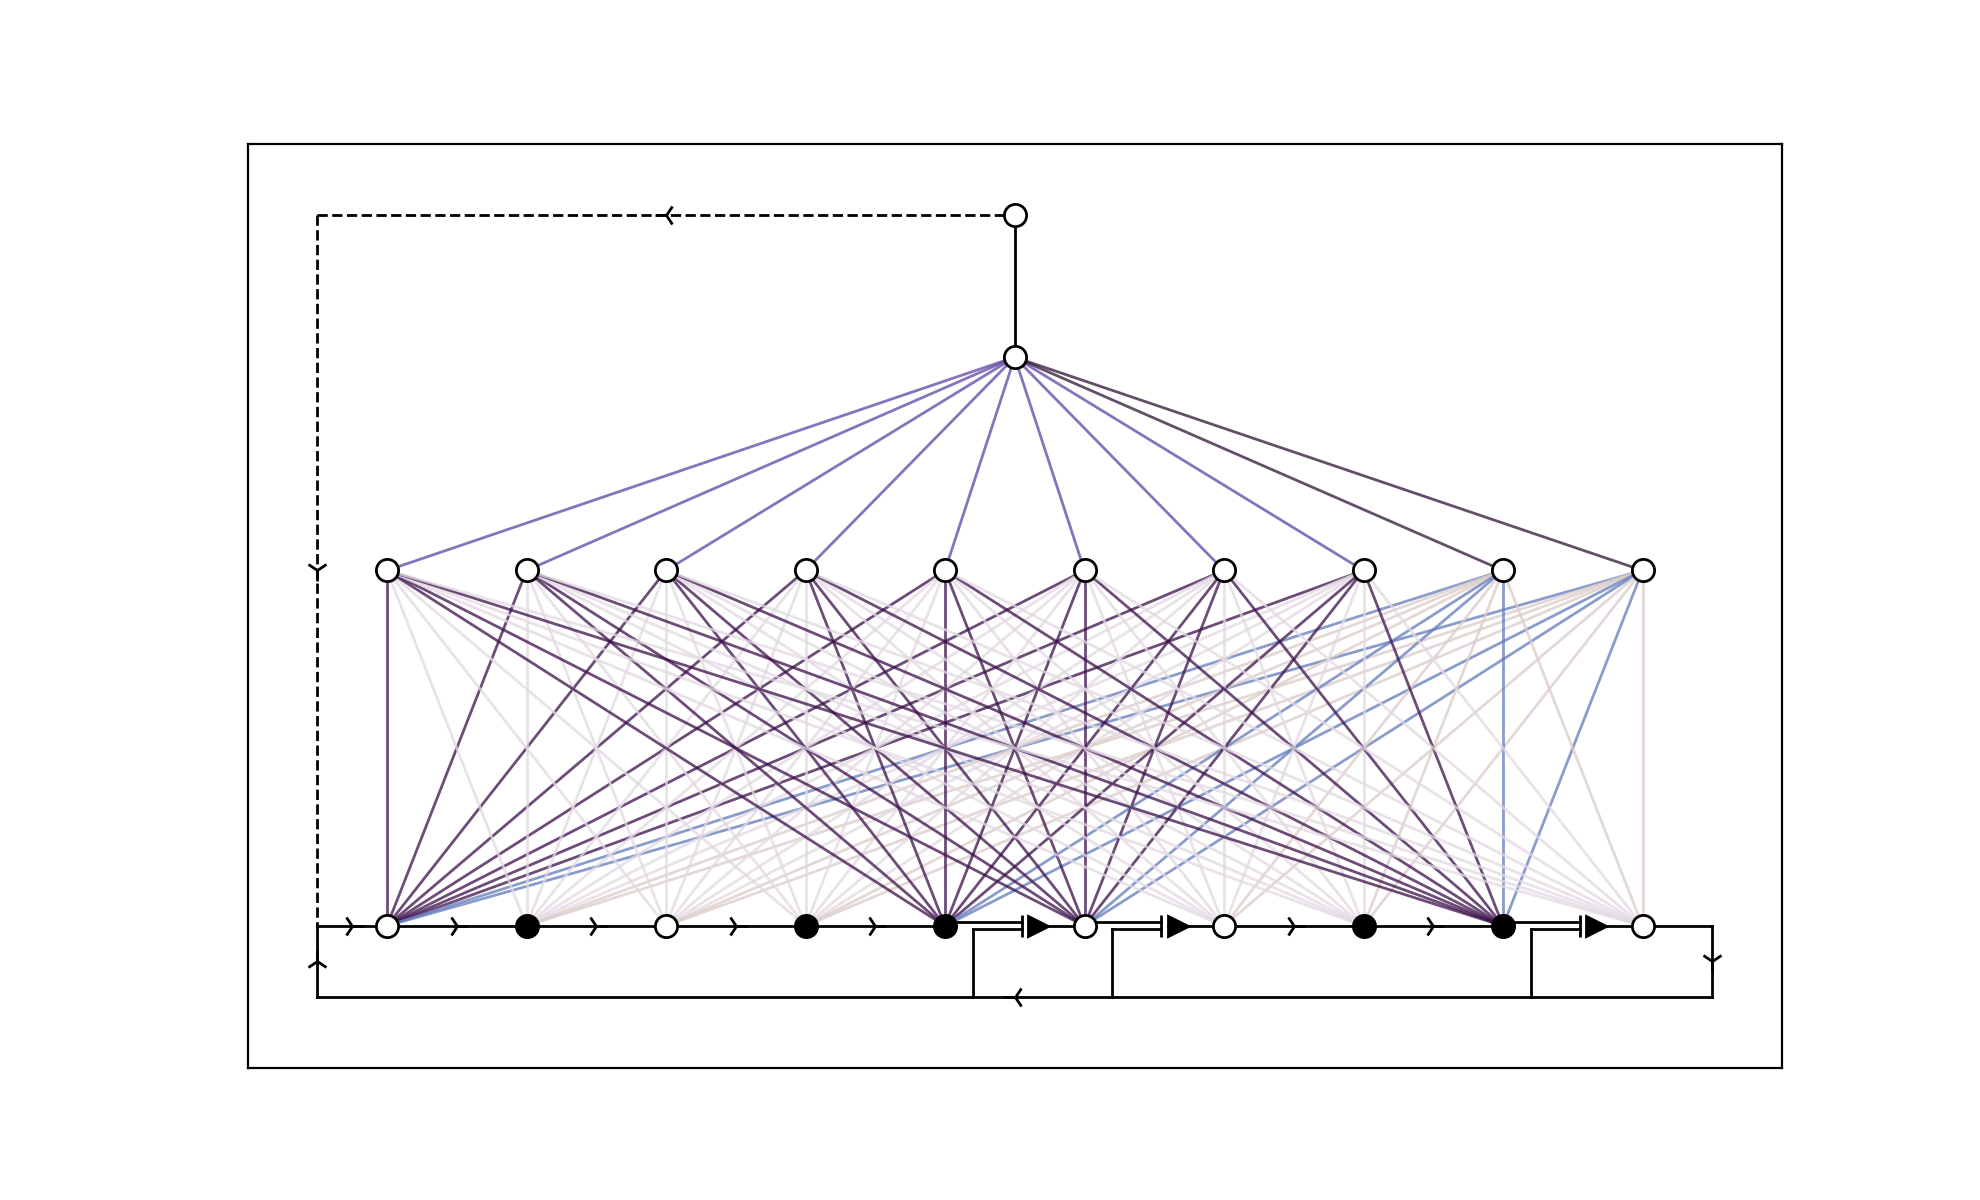

In [101]:
from numpy import max

config = {
    'figsize': (9.9, 6),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'twilight_shifted',
    'y_input': 0,
    'y_hidden': 0.5,
    'y_output': 0.8,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'y_lim': [-0.2, 1.1],
    'num_hidden': deg,
    'num_input': deg,
    'node_size': 8,
    'link_width': 1,
    'net_link_alpha': 0.75,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

#############################
# Set up shop in new figure #
#############################

# New figure
plt.figure(figsize=config['figsize'])

# Draw LFSR corrsponding to tap polynomial
draw_lfsr(taps=str2vec(hex2bin(
    coeff_catalog[p], config['deg'])), 
    deg=config['deg'], 
    x_midpt=config['x_mid'],
    y_register=config['y_input'],
    y_feedback=config['y_LFSR_loop'],
    arrow_size=config['arrow_size'],
    lw=config['link_width'])

# Initialize neural net drawing
init_network_diagram(model=model,
    config=config, seed_bits=X[0,:])

###############
# Format axes #
###############

# Vertical axis span
plt.ylim(config['y_lim']);

# Remove all axis ticks
plt.xticks([]);
plt.yticks([]);